Run notebook server with the following command:
```bash
poetry run python manage.py shell_plus --notebook
```
Dump data (needs to be done for DRN and OSM data):
```bash
poetry run python manage.py dumpdata composer composer.RouteLSABinding > db_<drn/osm>.json
```

In [16]:
def get_routes_with_bindings(data):
    routes = []
    bindings = []
    for entry in data:
        if entry["model"] == "composer.route":
            routes.append(entry)
        if entry["model"] == "composer.routelsabinding":
            bindings.append(entry)
    routes_with_bindings = {}
    for binding in bindings:
        if binding["fields"]["route"] not in routes_with_bindings:
            routes_with_bindings[binding["fields"]["route"]] = next(route for route in routes if route["pk"] == binding["fields"]["route"])
    return routes_with_bindings

def get_bindings_for_route_id(data, route_id):
    selected_lsa_ids = []
    for entry in data:
        if entry["model"] == "composer.routelsabinding" and entry["fields"]["route"] == route_id:
            selected_lsa_ids.append(entry["fields"]["lsa"])
    return selected_lsa_ids

from shapely.geometry import LineString as ShapelyLineString
from shapely import wkt
from routing.models import LSA
from django.conf import settings
from routing.matching.projection import project_onto_route

def get_distances(sg_ids, route_django_linestring):
    distances = []
    for sg_id in sg_ids:
        sg = LSA.objects.get(pk=sg_id)
        sg_geometry = sg.geometry
        sg_geometry_meter = sg_geometry.transform(settings.METRICAL, clone=True)
        route_django_linestring_meter = route_django_linestring.transform(settings.METRICAL, clone=True)
        sg_geometry_meter_projected = project_onto_route(sg_geometry_meter, route_django_linestring_meter)
        sg_geometry_meter_shapely = wkt.loads(sg_geometry_meter.wkt)
        sg_geometry_meter_projected_shapely = wkt.loads(sg_geometry_meter_projected.wkt)
        distances.append(sg_geometry_meter_shapely.hausdorff_distance(sg_geometry_meter_projected_shapely))
    return distances
    

# Import bindings

In [17]:
import json
import os
from django.conf import settings
from django.contrib.gis.geos import LineString
# Import DRN json file
f_drn = open('db_drn.json')
data_drn = json.load(f_drn)
routes_with_bindings_drn = get_routes_with_bindings(data_drn)
# Import OSM json file
f_osm = open('db_osm.json')
data_osm = json.load(f_osm)
routes_with_bindings_osm = get_routes_with_bindings(data_osm)

# Matching

In [19]:
from routing.matching.hypermodel import TopologicHypermodelMatcher
from routing.matching import get_matches

# DRN
tp_drn = []
tp_drn_distances = []
fp_drn = []
fp_drn_distances = []
fn_drn = []
fn_drn_distances = []
matchers_drn = [ TopologicHypermodelMatcher.from_config_file(f'config/topologic.hypermodel.drn.updated.json') ]
for route_id in routes_with_bindings_drn:
    routeGeometry = routes_with_bindings_drn[route_id]["fields"]["geometry"]
    srid = int(routeGeometry.split("=")[1].split(";")[0])
    points = [(float(point.split(" ")[0]), float(point.split(" ")[1])) for point in routeGeometry.replace("SRID=4326;LINESTRING (", "").replace(")","").split(", ")]
    linestring = LineString(points, srid=srid)
    matches = get_matches(linestring, matchers_drn)
    matched_lsas = [lsa.id for lsa in matches]
    selected_lsas = get_bindings_for_route_id(data_drn, routes_with_bindings_drn[route_id]["pk"])
    tp = list(set(matched_lsas) & set(selected_lsas))
    tp_drn_distances = tp_drn_distances + get_distances(tp, linestring)
    tp_drn = tp_drn + tp
    fp = list(set(matched_lsas) - set(selected_lsas))
    fp_drn_distances = fp_drn_distances + get_distances(fp, linestring)
    fp_drn = fp_drn + fp
    fn = list(set(selected_lsas) - set(matched_lsas))
    fn_drn_distances = fn_drn_distances + get_distances(fn, linestring)
    fn_drn = fn_drn + fn
    print(f"DRN TP: {len(tp_drn)}, FP: {len(fp_drn)}, FN: {len(fn_drn)}")
    print(f"DRN TP: {len(tp_drn_distances)}, FP: {len(fp_drn_distances)}, FN: {len(fn_drn_distances)}")
tp_drn_count = len(tp_drn)
fp_drn_count = len(fp_drn)
fn_drn_count = len(fn_drn)


DRN TP: 12, FP: 1, FN: 0
DRN TP: 12, FP: 1, FN: 0
DRN TP: 31, FP: 4, FN: 3
DRN TP: 31, FP: 4, FN: 3
DRN TP: 59, FP: 11, FN: 8
DRN TP: 59, FP: 11, FN: 8
DRN TP: 65, FP: 13, FN: 8
DRN TP: 65, FP: 13, FN: 8
DRN TP: 86, FP: 14, FN: 8
DRN TP: 86, FP: 14, FN: 8
DRN TP: 91, FP: 15, FN: 9
DRN TP: 91, FP: 15, FN: 9
DRN TP: 101, FP: 16, FN: 9
DRN TP: 101, FP: 16, FN: 9
DRN TP: 111, FP: 17, FN: 11
DRN TP: 111, FP: 17, FN: 11
DRN TP: 134, FP: 20, FN: 14
DRN TP: 134, FP: 20, FN: 14
DRN TP: 145, FP: 23, FN: 17
DRN TP: 145, FP: 23, FN: 17
DRN TP: 162, FP: 25, FN: 17
DRN TP: 162, FP: 25, FN: 17
DRN TP: 180, FP: 28, FN: 19
DRN TP: 180, FP: 28, FN: 19
DRN TP: 205, FP: 30, FN: 22
DRN TP: 205, FP: 30, FN: 22
DRN TP: 217, FP: 31, FN: 23
DRN TP: 217, FP: 31, FN: 23
DRN TP: 228, FP: 32, FN: 24
DRN TP: 228, FP: 32, FN: 24
DRN TP: 241, FP: 36, FN: 31
DRN TP: 241, FP: 36, FN: 31
DRN TP: 244, FP: 40, FN: 33
DRN TP: 244, FP: 40, FN: 33
DRN TP: 266, FP: 44, FN: 37
DRN TP: 266, FP: 44, FN: 37
DRN TP: 268, FP: 44, F

In [20]:
precision_drn = tp_drn_count / (tp_drn_count + fp_drn_count) if tp_drn_count + fp_drn_count > 0 else 0
recall_drn = tp_drn_count / (tp_drn_count + fn_drn_count) if tp_drn_count + fn_drn_count > 0 else 0
f1_drn = 2 * precision_drn * recall_drn / (precision_drn + recall_drn) if precision_drn + recall_drn > 0 else 0

json_drn = {
    "precision": precision_drn,
    "recall": recall_drn,
    "f1": f1_drn,
    "tp_drn": list(tp_drn),
    "tp_drn_distances": tp_drn_distances,
    "fp_drn": list(fp_drn),
    "fp_drn_distances": fp_drn_distances,
    "fn_drn": list(fn_drn),
    "fn_drn_distances": fn_drn_distances,
}

import json

with open('stats_drn.json', 'w') as fp:
    json.dump(json_drn, fp)

In [21]:
# OSM
tp_osm = []
tp_osm_distances = []
fp_osm = []
fp_osm_distances = []
fn_osm = []
fn_osm_distances = []
matchers_osm = [ TopologicHypermodelMatcher.from_config_file(f'config/topologic.hypermodel.osm.updated.json') ]
for route_id in routes_with_bindings_osm:
    routeGeometry = routes_with_bindings_osm[route_id]["fields"]["geometry"]
    srid = int(routeGeometry.split("=")[1].split(";")[0])
    points = [(float(point.split(" ")[0]), float(point.split(" ")[1])) for point in routeGeometry.replace("SRID=4326;LINESTRING (", "").replace(")","").split(", ")]
    linestring = LineString(points, srid=srid)
    matches = get_matches(linestring, matchers_osm)
    matched_lsas = [lsa.id for lsa in matches]
    selected_lsas = get_bindings_for_route_id(data_osm, routes_with_bindings_osm[route_id]["pk"])
    tp = list(set(matched_lsas) & set(selected_lsas))
    tp_osm_distances = tp_osm_distances + get_distances(tp, linestring)
    tp_osm = tp_osm + tp
    fp = list(set(matched_lsas) - set(selected_lsas))
    fp_osm_distances = fp_osm_distances + get_distances(fp, linestring)
    fp_osm = fp_osm + fp
    fn = list(set(selected_lsas) - set(matched_lsas))
    fn_osm_distances = fn_osm_distances + get_distances(fn, linestring)
    fn_osm = fn_osm + fn
    print(f"OSM TP: {len(tp_osm)}, FP: {len(fp_osm)}, FN: {len(fn_osm)}")
    print(f"OSM TP: {len(tp_osm_distances)}, FP: {len(fp_osm_distances)}, FN: {len(fn_osm_distances)}")


OSM TP: 26, FP: 5, FN: 3
DRN TP: 26, FP: 5, FN: 3
OSM TP: 53, FP: 10, FN: 8
DRN TP: 53, FP: 10, FN: 8
OSM TP: 59, FP: 10, FN: 8
DRN TP: 59, FP: 10, FN: 8
OSM TP: 61, FP: 12, FN: 8
DRN TP: 61, FP: 12, FN: 8
OSM TP: 63, FP: 14, FN: 8
DRN TP: 63, FP: 14, FN: 8
OSM TP: 78, FP: 21, FN: 13
DRN TP: 78, FP: 21, FN: 13
OSM TP: 83, FP: 22, FN: 15
DRN TP: 83, FP: 22, FN: 15
OSM TP: 85, FP: 22, FN: 15
DRN TP: 85, FP: 22, FN: 15
OSM TP: 86, FP: 22, FN: 16
DRN TP: 86, FP: 22, FN: 16
OSM TP: 92, FP: 23, FN: 18
DRN TP: 92, FP: 23, FN: 18
OSM TP: 97, FP: 23, FN: 22
DRN TP: 97, FP: 23, FN: 22
OSM TP: 122, FP: 23, FN: 23
DRN TP: 122, FP: 23, FN: 23
OSM TP: 122, FP: 25, FN: 25
DRN TP: 122, FP: 25, FN: 25
OSM TP: 179, FP: 37, FN: 31
DRN TP: 179, FP: 37, FN: 31
OSM TP: 180, FP: 37, FN: 31
DRN TP: 180, FP: 37, FN: 31
OSM TP: 183, FP: 37, FN: 31
DRN TP: 183, FP: 37, FN: 31
OSM TP: 194, FP: 39, FN: 37
DRN TP: 194, FP: 39, FN: 37
OSM TP: 206, FP: 40, FN: 39
DRN TP: 206, FP: 40, FN: 39
OSM TP: 233, FP: 45, FN: 4

In [22]:
tp_osm_count = len(tp_osm)
fp_osm_count = len(fp_osm)
fn_osm_count = len(fn_osm)
precision_osm = tp_osm_count / (tp_osm_count + fp_osm_count) if tp_osm_count + fp_osm_count > 0 else 0
recall_osm = tp_osm_count / (tp_osm_count + fn_osm_count) if tp_osm_count + fn_osm_count > 0 else 0
f1_osm = 2 * precision_osm * recall_osm / (precision_osm + recall_osm) if precision_osm + recall_osm > 0 else 0

json_osm = {
    "precision": precision_osm,
    "recall": recall_osm,
    "f1": f1_osm,
    "tp_osm": list(tp_osm),
    "tp_osm_distances": tp_osm_distances,
    "fp_osm": list(fp_osm),
    "fp_osm_distances": fp_osm_distances,
    "fn_osm": list(fn_osm),
    "fn_osm_distances": fn_osm_distances,
}

import json

with open('stats_osm.json', 'w') as fp:
    json.dump(json_osm, fp)

# Import stats and generate chart

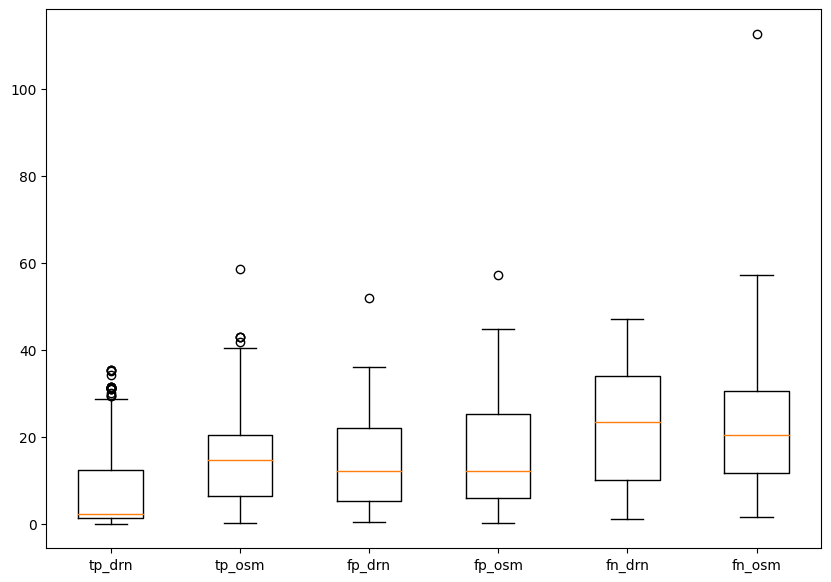

In [2]:
%matplotlib inline

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def get_stats(distances_list):
    min_value = min(distances_list)
    max_value = max(distances_list)
    first_quartile = np.percentile(distances_list, 25)
    median = np.percentile(distances_list, 50)
    third_quartile = np.percentile(distances_list, 75)
    return (min_value, max_value, first_quartile, median, third_quartile)


# Import DRN json file
f_drn = open('stats_drn.json')
stats_drn = json.load(f_drn)
tp_drn_stats = get_stats(stats_drn["tp_drn_distances"])
fp_drn_stats = get_stats(stats_drn["fp_drn_distances"])
fn_drn_stats = get_stats(stats_drn["fn_drn_distances"])

# Import OSM json file
f_osm = open('stats_osm.json')
stats_osm = json.load(f_osm)
tp_osm_stats = get_stats(stats_osm["tp_osm_distances"])
fp_osm_stats = get_stats(stats_osm["fp_osm_distances"])
fn_osm_stats = get_stats(stats_osm["fn_osm_distances"])

data = [stats_drn["tp_drn_distances"],
        stats_osm["tp_osm_distances"],
        stats_drn["fp_drn_distances"],
        stats_osm["fp_osm_distances"],
        stats_drn["fn_drn_distances"],
        stats_osm["fn_osm_distances"]]

fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data, labels=["tp_drn", "tp_osm", "fp_drn", "fp_osm", "fn_drn", "fn_osm"])
 
# show plot
plt.show()

In [18]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import numpy as np

init_notebook_mode(connected=True)

steps = 5

def get_bins(distances, max_value):
    bins = []
    i = 0
    while i < max_value:
        i += steps
        bins.append(sum(1 for distance in distances if distance < i and distance >= (i - 5)))
    return bins
    
# Import DRN json file
f_drn = open('stats_drn.json')
stats_drn = json.load(f_drn)
tp_drn_stats = get_stats(stats_drn["tp_drn_distances"])
fp_drn_stats = get_stats(stats_drn["fp_drn_distances"])
fn_drn_stats = get_stats(stats_drn["fn_drn_distances"])

# Import OSM json file
f_osm = open('stats_osm.json')
stats_osm = json.load(f_osm)

max_value = max([
    max(stats_drn["tp_drn_distances"]),
    max(stats_drn["fp_drn_distances"]),
    max(stats_drn["fn_drn_distances"]),
    max(stats_osm["tp_osm_distances"]),
    max(stats_osm["fp_osm_distances"]),
    max(stats_osm["fn_osm_distances"])])

import math
max_value = math.ceil(max_value)

tp_drn_bins = get_bins(stats_drn["tp_drn_distances"], max_value)
fp_drn_bins = get_bins(stats_drn["fp_drn_distances"], max_value)
fn_drn_bins = get_bins(stats_drn["fn_drn_distances"], max_value)

tp_osm_bins = get_bins(stats_osm["tp_osm_distances"], max_value)
fp_osm_bins = get_bins(stats_osm["fp_osm_distances"], max_value)
fn_osm_bins = get_bins(stats_osm["fn_osm_distances"], max_value)

tp_osm_bins = [ -x for x in tp_osm_bins]
fp_osm_bins = [ -x for x in fp_osm_bins]
fn_osm_bins = [ -x for x in fn_osm_bins]

y = list(range(0, max_value, steps))

layout = go.Layout(yaxis=go.layout.YAxis(title='Discrete Hausdorff Distance in meter'),
                   xaxis=go.layout.XAxis(
                       range=[-500, 500],
                       title='Amount'),
                   barmode='overlay',
                   bargap=0.1)

data_tp = [
        go.Bar(y=y,
               x=tp_osm_bins,
               orientation='h',
               name='TP OSM',
               hoverinfo='text',
               marker=dict(color='seagreen')
               ),
        go.Bar(y=y,
               x=tp_drn_bins,
               orientation='h',
               name='TP DRN',
               hoverinfo='x',
               marker=dict(color='powderblue')
               )]

data_fp = [
        go.Bar(y=y,
               x=fp_osm_bins,
               orientation='h',
               name='FP OSM',
               hoverinfo='text',
               marker=dict(color='seagreen')
               ),
        go.Bar(y=y,
               x=fp_drn_bins,
               orientation='h',
               name='FP DRN',
               hoverinfo='x',
               marker=dict(color='powderblue')
               )]

data_fn = [
        go.Bar(y=y,
               x=fn_osm_bins,
               orientation='h',
               name='FN OSM',
               hoverinfo='text',
               marker=dict(color='seagreen')
               ),
        go.Bar(y=y,
               x=fn_drn_bins,
               orientation='h',
               name='FN DRN',
               hoverinfo='x',
               marker=dict(color='powderblue')
               )]

iplot(dict(data=data_tp, layout=layout))
iplot(dict(data=data_fp, layout=layout))
iplot(dict(data=data_fn, layout=layout))
    

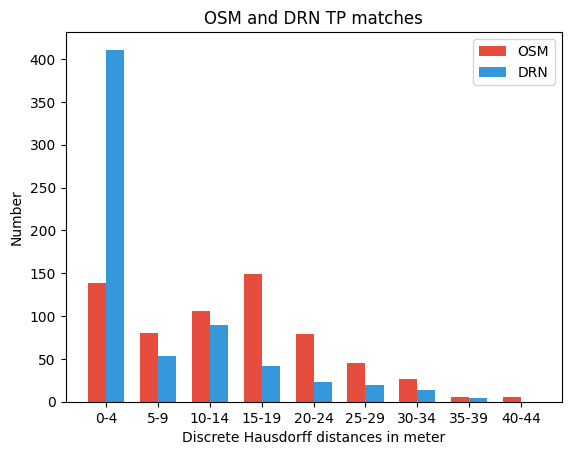

In [27]:
%matplotlib inline

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

steps = 5
width = 0.35       # the width of the bars

def get_bins(distances, max_value):
    max_value = 45
    bins = {}
    i = 0
    while i < max_value:
        i += steps
        bins[f"{i-steps}-{i-1}"] = sum(1 for distance in distances if distance < i and distance >= (i - 5))
    return bins
    
# Import DRN json file
f_drn = open('stats_drn.json')
stats_drn = json.load(f_drn)
tp_drn_stats = get_stats(stats_drn["tp_drn_distances"])
fp_drn_stats = get_stats(stats_drn["fp_drn_distances"])
fn_drn_stats = get_stats(stats_drn["fn_drn_distances"])

# Import OSM json file
f_osm = open('stats_osm.json')
stats_osm = json.load(f_osm)

max_value = max([
    max(stats_drn["tp_drn_distances"]),
    max(stats_drn["fp_drn_distances"]),
    max(stats_drn["fn_drn_distances"]),
    max(stats_osm["tp_osm_distances"]),
    max(stats_osm["fp_osm_distances"]),
    max(stats_osm["fn_osm_distances"])])

import math
max_value = math.ceil(max_value)

tp_drn_bins = get_bins(stats_drn["tp_drn_distances"], max_value)
fp_drn_bins = get_bins(stats_drn["fp_drn_distances"], max_value)
fn_drn_bins = get_bins(stats_drn["fn_drn_distances"], max_value)

tp_osm_bins = get_bins(stats_osm["tp_osm_distances"], max_value)
fp_osm_bins = get_bins(stats_osm["fp_osm_distances"], max_value)
fn_osm_bins = get_bins(stats_osm["fn_osm_distances"], max_value)

tp_osm_bar = plt.bar(tp_osm_bins.keys(), tp_osm_bins.values(), -width, align='edge', color="#e74d3c", label='OSM')
tp_drn_bar = plt.bar(tp_drn_bins.keys(), tp_drn_bins.values(), +width, align='edge', color='#3498db', label='DRN')

# add some text for labels, title and axes ticks
plt.xlabel('Discrete Hausdorff distances in meter')
plt.ylabel('Number')
plt.title('OSM and DRN TP matches')
plt.legend()

plt.show()